In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Decadal variability of WMT in GFDL's OM4
JRA forcing  

In [106]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
import gsw
import wmt_bgc.basic as wmt
%matplotlib inline

In [107]:
# Load the data
# (from restart)
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filename = pp+'.*.nc'
ds = xr.open_mfdataset(rootdir+pp+localdir+filename)
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')

In [108]:
# Specification for heat and salt budgets
variables = {'heat':'thetao','salt':'so'}
terms = {}
terms['heat']=['opottemptend','T_advection_xy','Th_tendency_vert_remap',
               'boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
terms['salt']=['osalttend','S_advection_xy','Sh_tendency_vert_remap',
               'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']

In [109]:
# Preprocess
# Isolate Southern Ocean
ds_SO = ds.isel(z_l=slice(0,5)).sel(yh=slice(-90,-30),yq=slice(-90,-30))
# Calculate density
sigma0 = gsw.sigma0(ds_SO['so'],ds_SO['thetao'])
ds_SO['sigma0'] = xr.DataArray(sigma0,dims=ds_SO['so'].dims,coords=ds_SO['so'].coords)
# Calculate density flux
# alpha = gsw.alpha(ds_SO['so'],ds_SO['thetao'],ds_SO['z_l']*xr.ones_like(ds_SO['so']))
# ds_SO['alpha'] = xr.DataArray(alpha,dims=ds_SO['so'].dims,coords=ds_SO['so'].coords)
# beta = gsw.beta(ds_SO['so'],ds_SO['thetao'],ds_SO['z_l']*xr.ones_like(ds_SO['so']))
# ds_SO['beta'] = xr.DataArray(beta,dims=ds_SO['so'].dims,coords=ds_SO['so'].coords)
densityflux = wmt.calc_densityflux(ds_SO['boundary_forcing_heat_tendency'],
                                   -ds_SO['boundary_forcing_salt_tendency'],
                                   S=ds['so'])

In [110]:
# Histogram boundary fluxes by density
sigma0_bins = np.arange(22,30,0.1)
mask = np.isnan(ds_SO['sigma0'])
# heatflux = (ds_SO['boundary_forcing_heat_tendency']*ds_SO['volcello']).where(~mask)
# heatflux_binned = histogram(ds_SO['sigma0'].where(~mask),
#                             bins=[sigma0_bins],
#                             dim=['xh','yh','z_l'],
#                             weights=heatflux)
# saltflux = (ds_SO['boundary_forcing_salt_tendency']*ds_SO['volcello']).where(~mask)
# saltflux_binned = histogram(ds_SO['sigma0'].where(~mask),
#                             bins=[sigma0_bins],
#                             dim=['xh','yh','z_l'],
#                             weights=saltflux)
densityflux_binned = xr.Dataset()
for term in densityflux.data_vars:
    print(term)
    flux = (densityflux[term]*grid['areacello']).where(~mask)
    densityflux_binned[term] = histogram(ds_SO['sigma0'].where(~mask),
                            bins=[sigma0_bins],
                            dim=['xh','yh','z_l'],
                            weights=flux)

densityflux_Qheat
densityflux_Qfw
densityflux


In [111]:
# heatflux_binned.load()
# saltflux_binned.load()
densityflux_binned.load()

<xarray.Dataset>
Dimensions:            (sigma0_bin: 79, time: 60)
Coordinates:
  * time               (time) object 1958-07-02 12:00:00 ... 2017-07-02 12:00:00
  * sigma0_bin         (sigma0_bin) float64 22.05 22.15 22.25 ... 29.75 29.85
Data variables:
    densityflux_Qheat  (time, sigma0_bin) float64 2.587e+03 2.015e+03 ... 0.0
    densityflux_Qfw    (time, sigma0_bin) float64 298.8 220.4 250.5 ... 0.0 0.0
    densityflux        (time, sigma0_bin) float64 2.886e+03 2.236e+03 ... 0.0

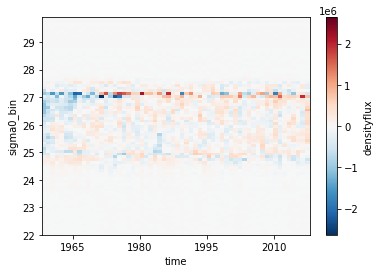

In [112]:
(densityflux_binned['densityflux']-densityflux_binned['densityflux'].mean('time')).transpose().plot()

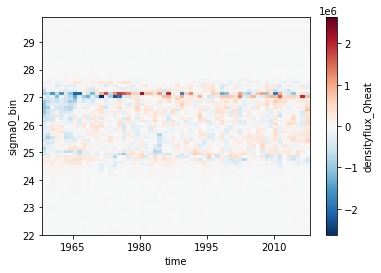

In [113]:
(densityflux_binned['densityflux_Qheat']-densityflux_binned['densityflux_Qheat'].mean('time')).transpose().plot()

In [120]:
# Calculate water mass transformation
rho0 = 1035.0
dsigma0 = xr.DataArray(np.diff(sigma0_bins),
                  dims=['sigma0_bin'],
                  coords={'sigma0_bin':densflux_binned['sigma0_bin']})
G = xr.Dataset()
for term in densityflux.data_vars:
    print(term)
    G[term] = rho0*densityflux_binned[term]/dsigma0

densityflux_Qheat
densityflux_Qfw
densityflux


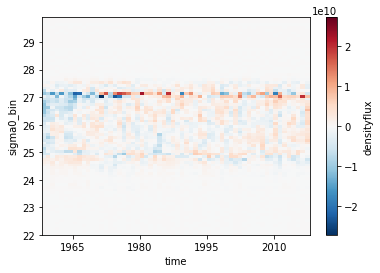

In [121]:
(G['densityflux']-G['densityflux'].mean('time')).transpose().plot()

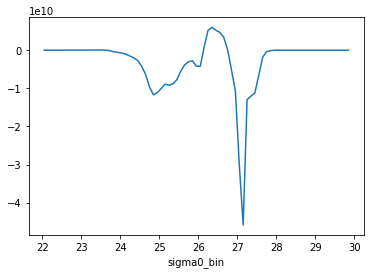

In [117]:
G.mean('time').plot()

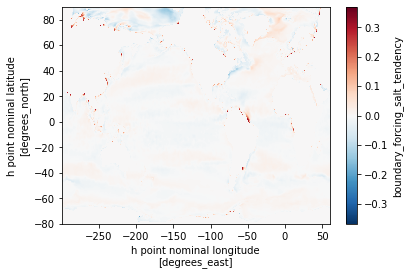

In [118]:
(3E7*ds['boundary_forcing_salt_tendency'].sum('z_l').mean('time')/rho0).plot()

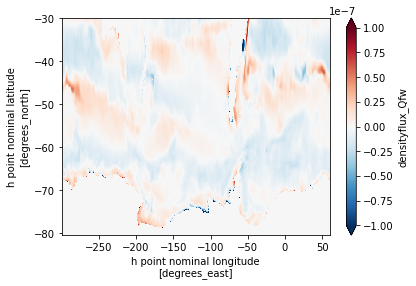

In [88]:
densityflux['densityflux_Qfw'].sum('z_l').mean('time').plot(vmax=1E-7)

In [119]:
ds['boundary_forcing_salt_tendency']

<xarray.DataArray 'boundary_forcing_salt_tendency' (time: 60, z_l: 35, yh: 1080, xh: 1440)>
dask.array<concatenate, shape=(60, 35, 1080, 1440), dtype=float32, chunksize=(5, 35, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 1958-07-02 12:00:00 ... 2017-07-02 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:      Boundary forcing salt tendency
    units:          kg m-2 s-1
    cell_methods:   area:mean z_l:sum yh:mean xh:mean time: mean
    cell_measures:  volume: volcello area: areacello
    time_avg_info:  average_T1,average_T2,average_DT